In [2]:
import numpy as np 
import pandas as pd
import json


path = "C:/Users/brand/desktop/events/events_England.json" 
with open(path) as f:
    data = json.load(f)

train = pd.DataFrame(data)

path2 = "C:/Users/brand/desktop/players.json" 

with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)




pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1


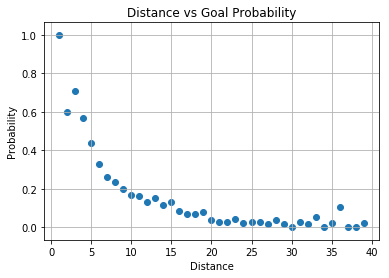

In [8]:
from matplotlib import pyplot as plt

ranges = np.arange(1,40)
d = {n:[0,0] for n in ranges}

for index,row in shots_model.iterrows():
    
    dist = round(row['Distance'])
    if dist < 39:
        d[dist][1] += 1
        
        if row['Goal'] == 1:
            d[dist][0] +=1
    
    else:
        d[39][1] +=1
            
        if row['Goal'] == 1:
            d[39][0] += 1

#print(d)
yaxis = []
for i in range(1,40):
    d[i] = d[i][0]/d[i][1]
    yaxis.append(d[i])

#print(yaxis)


plt.scatter(ranges,yaxis,cmap = 'spectral')
plt.grid()
plt.xlabel('Distance')
plt.ylabel('Probability')
plt.title('Distance vs Goal Probability')
plt.show()

{0: [1, 1], 1: [3, 46], 2: [22, 688], 3: [83, 2711], 4: [107, 1503], 5: [123, 981], 6: [131, 841], 7: [85, 488], 8: [72, 370], 9: [55, 225], 10: [35, 121], 11: [38, 128], 12: [26, 92], 13: [18, 43], 14: [27, 64], 15: [10, 23], 16: [28, 50], 17: [2, 3], 18: [8, 12], 19: [5, 9], 20: [18, 23], 21: [0, 0], 22: [1, 2], 23: [6, 10], 24: [5, 11], 25: [0, 0], 26: [0, 0], 27: [0, 0], 28: [0, 0], 29: [5, 5]}


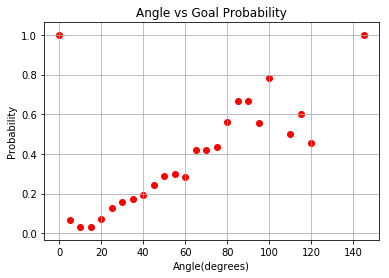

In [4]:
angles = np.arange(0,150,5)
angles_dict = {n:[0,0] for n in range(30)}



for index,row in shots_model.iterrows():
    
    ang = round(row['angle_degrees'] / 5)
    
    angles_dict[ang][1] += 1
    
    if row['Goal'] == 1:
        angles_dict[ang][0] += 1

print(angles_dict)
yaxis2 = []
xaxis2 = []
count = 0
for i in range(30):
    if angles_dict[i][1] > 0:
        yaxis2.append(angles_dict[i][0]/angles_dict[i][1])
        xaxis2.append(count)
        count += 5
    
    else:
        count += 5

plt.scatter(xaxis2,yaxis2,c = 'r')
plt.grid()
plt.xlabel('Angle(degrees)')
plt.ylabel('Probability')
plt.title('Angle vs Goal Probability')
plt.show()
    
    
    
    
    

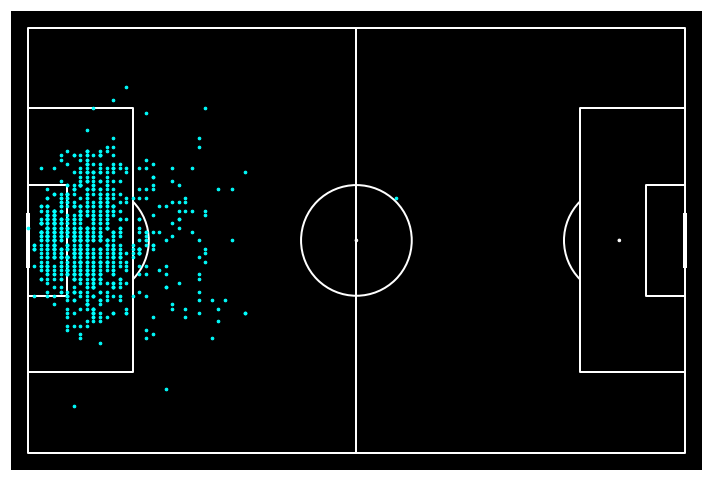

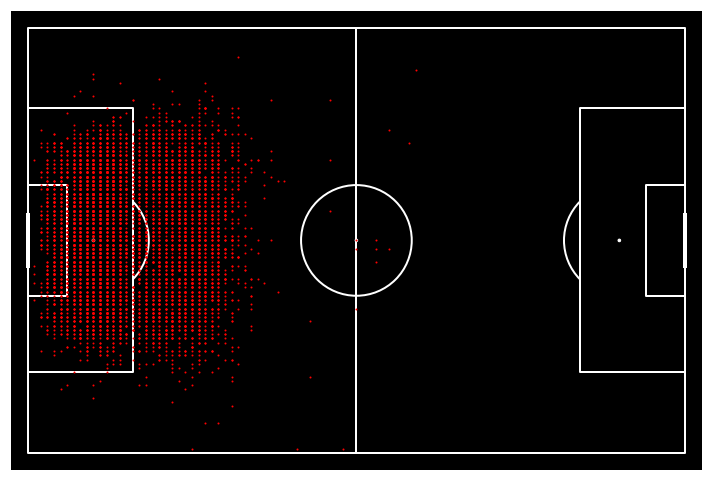

In [5]:
from mplsoccer.pitch import Pitch, VerticalPitch

pitch = Pitch(pitch_color ='black', line_color = 'white', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

df = shots_model.loc[shots_model['Goal'] == 1]
xpos = df["X"]
ypos = df["Y"]

df_nongoals = shots_model.loc[shots_model['Goal'] == 0]
xpos2 = df_nongoals["X"]
ypos2 = df_nongoals["Y"]


sc1 = pitch.scatter(xpos, ypos,
                    # size varies between 100 and 1900 (points squared)
                    s=7,
                      # give the markers a charcoal border
                    c='cyan',  # no facecolor for the markers
                    
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',ax=ax )




pitch2 = VerticalPitch(pitch_color ='white', line_color = 'grey', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

sc2 = pitch.scatter(xpos2, ypos2,
                    # size varies between 100 and 1900 (points squared)
                    s=1,
                      # give the markers a charcoal border
                    c='red',  # no facecolor for the markers
                    
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',ax=ax )

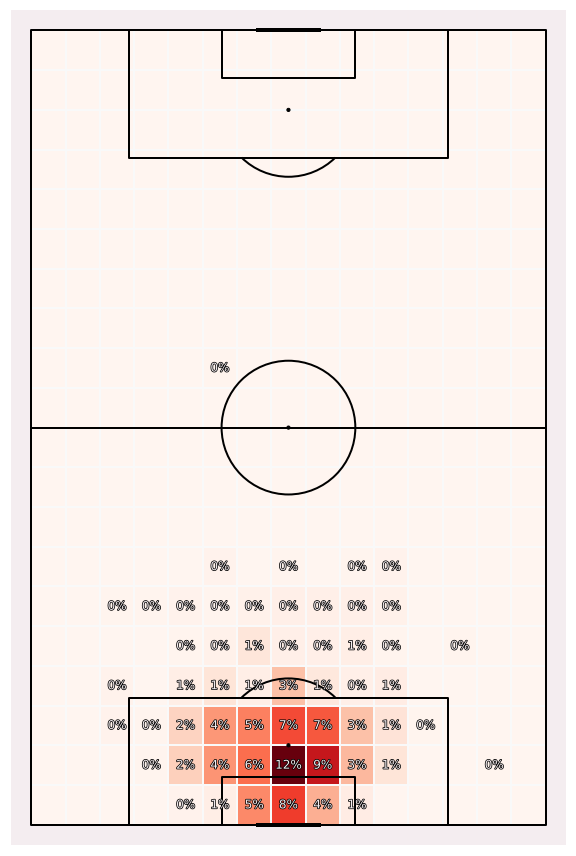

In [6]:
import matplotlib.patheffects as path_effects

path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]



pitch = VerticalPitch(pitch_color ='#f4edf0', line_color = 'black',line_zorder = 2, stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,12))



bin_statistic = pitch.bin_statistic(df.X.astype(float),df.Y.astype(float),statistic='count',bins=(20,15),normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds',edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects = path_eff,exclude_zeros = True)






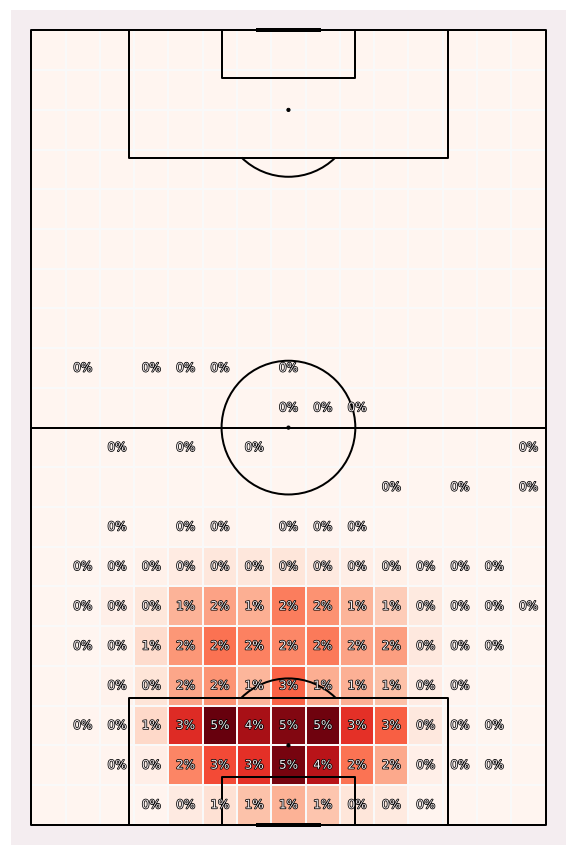

In [7]:


pitch = VerticalPitch(pitch_color ='#f4edf0', line_color = 'black',line_zorder = 2, stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,12))



bin_statistic = pitch.bin_statistic(shots_model.X.astype(float),shots_model.Y.astype(float),statistic='count',bins=(20,15),normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds',edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects = path_eff,exclude_zeros = True)



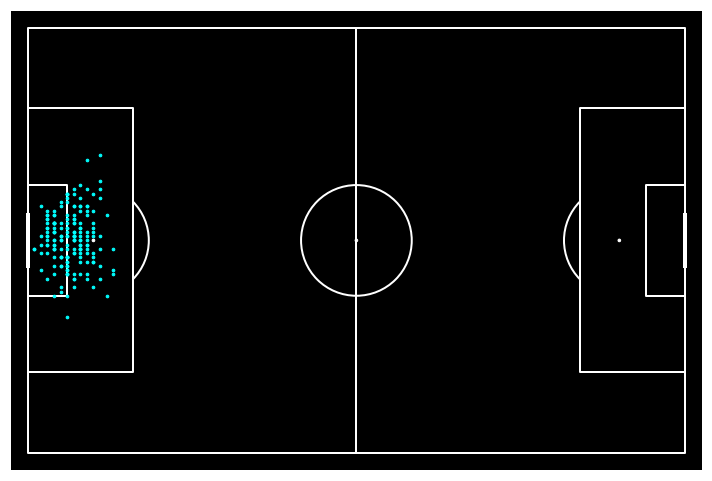

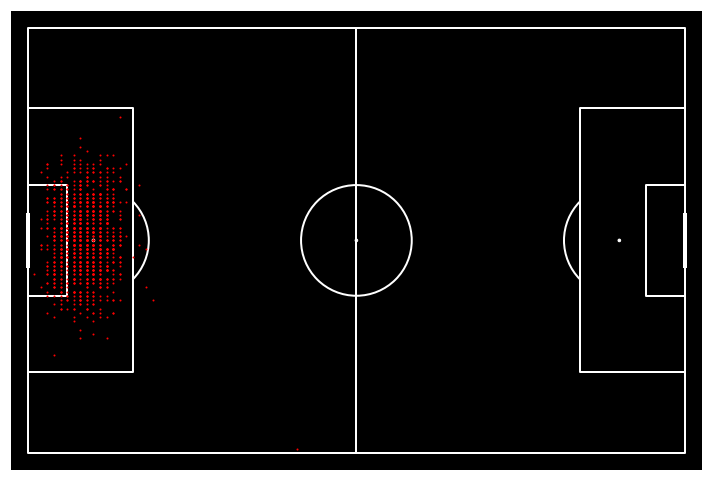

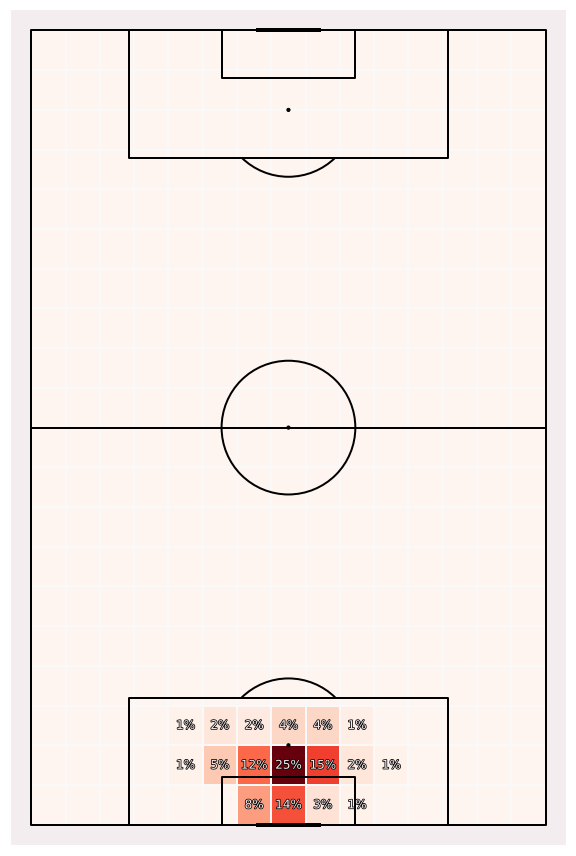

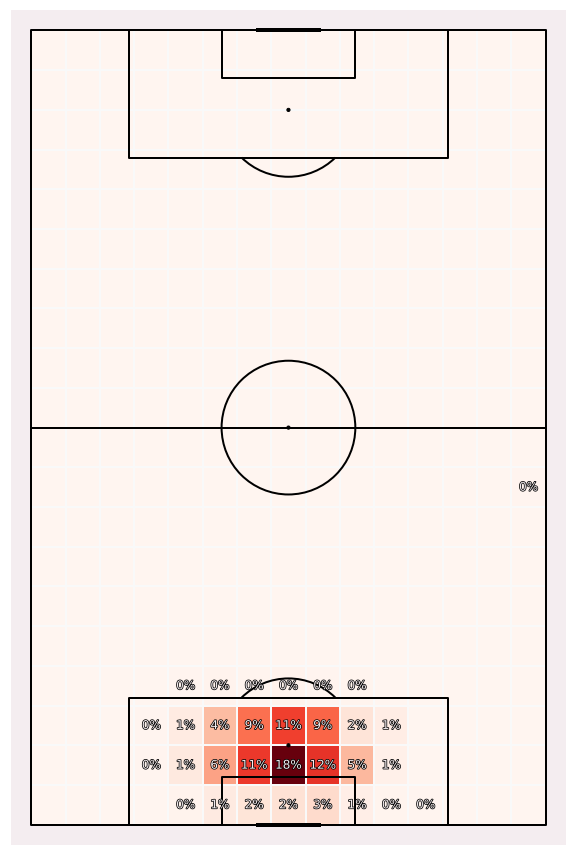

In [12]:
"""Headers"""
head = shots_model[shots_model['Header'] == 1]
counter = shots_model[shots_model['Counter Attack'] == 1]
strong = shots_model[shots_model['strong foot'] == 1]
first = shots_model[shots_model['First Half'] == 1]


pitch = Pitch(pitch_color ='black', line_color = 'white', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

head_df = head.loc[head['Goal'] == 1]
xpos = head_df["X"]
ypos = head_df["Y"]

head_df_nongoals = head.loc[head['Goal'] == 0]
xpos2 = head_df_nongoals["X"]
ypos2 = head_df_nongoals["Y"]


sc1 = pitch.scatter(xpos, ypos,
                    # size varies between 100 and 1900 (points squared)
                    s=7,
                      # give the markers a charcoal border
                    c='cyan',  # no facecolor for the markers
                    
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',ax=ax )




pitch2 = VerticalPitch(pitch_color ='white', line_color = 'grey', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

sc2 = pitch.scatter(xpos2, ypos2,
                    # size varies between 100 and 1900 (points squared)
                    s=1,
                      # give the markers a charcoal border
                    c='red',  # no facecolor for the markers
                    
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',ax=ax )


pitch = VerticalPitch(pitch_color ='#f4edf0', line_color = 'black',line_zorder = 2, stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,12))



bin_statistic = pitch.bin_statistic(xpos.astype(float),ypos.astype(float),statistic='count',bins=(20,15),normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds',edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects = path_eff,exclude_zeros = True)



pitch = VerticalPitch(pitch_color ='#f4edf0', line_color = 'black',line_zorder = 2, stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,12))



bin_statistic = pitch.bin_statistic(xpos2.astype(float),ypos2.astype(float),statistic='count',bins=(20,15),normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds',edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects = path_eff,exclude_zeros = True)

0.1976470588235294
0.10342679127725857
-----
0.1023968981318294
0.11995677233429394
--------
0.09815330129015937
0.11696686680008894


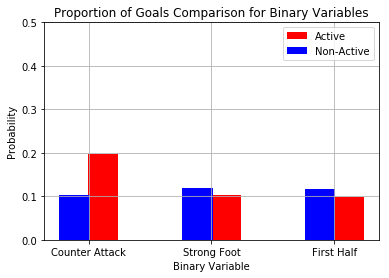

In [55]:
"""Comparison of Data's Binary Variables"""

"""Headers"""

headed_goals = len(head_df)
prob_headed_goals = headed_goals/len(head)


"""Counter Attack"""

numb_counters = len(counter)
counter_goals = len(counter.loc[counter['Goal'] == 1])
prob_counter = counter_goals/numb_counters

non_counter = shots_model[shots_model['Counter Attack'] == 0]
non_counter_goals = non_counter.loc[non_counter['Goal'] == 1]

prob_non_counter = len(non_counter_goals) / len(non_counter)


print(prob_counter)
print(prob_non_counter)
print('-----')
"""Strong foot vs weak foot"""

weak = shots_model[shots_model['strong foot'] == 0]
numb_strong = len(strong)
numb_weak = len(weak) 
weak_goals = weak.loc[weak['Goal'] == 1]

strong_goals = len(strong.loc[strong['Goal'] == 1])
prob_strong = strong_goals/numb_strong
prob_weak = len(weak_goals) / len(weak)

print(prob_strong)
print(prob_weak)
print('--------')

"""First Half vs Second Half"""
first_goals = len(first.loc[first['Goal'] == 1])
second_shots = shots_model[shots_model['First Half'] == 0]
second_goals = second_shots.loc[second_shots['Goal'] == 1]


prob_first = first_goals/len(first)
prob_second = len(second_goals) / len(second_shots)

print(prob_first)
print(prob_second)


stat = ['Counter Attack','Strong Foot', 'First Half']
probs = [prob_counter, prob_strong, prob_first]
probs2 = [prob_non_counter, prob_weak, prob_second]

ypos = np.arange(len(stat))
plt.xticks(ypos,stat)
plt.xlabel('Binary Variable')
plt.ylabel('Probability')
plt.title("Proportion of Goals Comparison for Binary Variables")

plt.ylim(0,.5)

plt.grid()
plt.bar(ypos + 0.115, probs,width=0.25,label="Active",color='r')
plt.bar(ypos - 0.115 , probs2,width=0.25,label="Non-Active",color='b')
plt.legend()
plt.show()